In [47]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys

from utils import *
from circuit_extract import visualize_circuit_masks
import circuit_extract as ce
import inference
import train
from copy import deepcopy

In [122]:
import importlib

importlib.reload(inference)
importlib.reload(train)
importlib.reload(ce)

<module 'circuit_extract' from '/home/cabbagepatch/Code/MI/vast/Mechanistic-Interpretability/circuit_extract.py'>

In [123]:
def model_config(ds_name: str, lr: float, epochs: int, seed: int=0):
    return {
        "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "seed": seed,
        "dataset": ds_name,
        "epochs": epochs, 
        "lr": lr,
        # "pfrac": pfrac,
    }

def circuit_config(ds_name: str, lr: float, cepochs: int, k_w: int, seed: int=0):
    return {
        "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "seed": seed,
        "dataset": ds_name,
        "cepochs": cepochs, 
        "lr": lr,
        "k_w": k_w,
    }
    

### Train Sparse Model ###

In [124]:
print("\n--- Phase 1: Initialize Model ---")
inp_shape = (1, 28, 28)
model = inference.CNN(nc=1, nf=16, num_classes=10, inp_shape=inp_shape)


--- Phase 1: Initialize Model ---


In [125]:
print("\n--- Phase 2: Train Sparse Baseline ---")

epochs = 30
sched = scheduler(5, epochs-5, 1, 0.05, 0.5)
# sched(0)
# for epoch in range(1,epochs):
#     print(sched(epoch+1))

cfg = model_config(ds_name='mnist', lr=1e-3, epochs=epochs)
device = cfg['device']
print(f"Running on {device}")

train.train_model(
    model=model,
    lr=cfg['lr'],
    b1=0.9, b2=0.999,
    # pfrac=cfg['pfrac'],
    scheduler = sched, 
    ds_name="mnist-baseline",
    eps=1e-8,
    epochs=cfg['epochs'],
    device=device,
    seed=cfg['seed']
)


--- Phase 2: Train Sparse Baseline ---
Running on cpu
n_params 20432 n_params_wd 20432
cpu


/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0 | Train Acc: 0.9771 | Test Acc: 0.9768
Epoch 1 | Train Acc: 0.9848 | Test Acc: 0.9828
Epoch 2 | Train Acc: 0.9871 | Test Acc: 0.9848
Epoch 3 | Train Acc: 0.9890 | Test Acc: 0.9868
Epoch 4 | Train Acc: 0.9913 | Test Acc: 0.9882
Epoch 5 | Train Acc: 0.9277 | Test Acc: 0.9300
Epoch 6 | Train Acc: 0.9307 | Test Acc: 0.9331
Epoch 7 | Train Acc: 0.9528 | Test Acc: 0.9548
Epoch 8 | Train Acc: 0.9538 | Test Acc: 0.9540
Epoch 9 | Train Acc: 0.9542 | Test Acc: 0.9561
Epoch 10 | Train Acc: 0.9640 | Test Acc: 0.9654
Epoch 11 | Train Acc: 0.9653 | Test Acc: 0.9653
Epoch 12 | Train Acc: 0.9727 | Test Acc: 0.9712
Epoch 13 | Train Acc: 0.9573 | Test Acc: 0.9559
Epoch 14 | Train Acc: 0.9732 | Test Acc: 0.9713
Epoch 15 | Train Acc: 0.9739 | Test Acc: 0.9733
Epoch 16 | Train Acc: 0.9762 | Test Acc: 0.9745
Epoch 17 | Train Acc: 0.9749 | Test Acc: 0.9733
Epoch 18 | Train Acc: 0.9711 | Test Acc: 0.9717
Epoch 19 | Train Acc: 0.9735 | Test Acc: 0.9697
Epoch 20 | Train Acc: 0.9720 | Test Acc: 0.9696
Ep

In [126]:
print(f'CUDA available: {torch.cuda.is_available()}') 
print(f'Device count: {torch.cuda.device_count()}')
print(f'Current device: {torch.cuda.current_device() if torch.cuda.is_available() else None}')


CUDA available: False
Device count: 0
Current device: None


In [127]:
non_zero = sum([(p != 0).sum() for p in model.parameters()])
total = sum([p.numel() for p in model.parameters()])

print(f"{non_zero/total:.4f}")
 
# when retaining also retain other ones
# scheduler also add (50 percent of training steos then reach sparsity)
# iteratively sparsify features after starting from 0 percent sparsty
# circuits should not rely on 
# for every neuron retain some weights
# try pretraining on generation
#try on more complex datasets, cmnist, cifar10, pacs
#maybe try portability
#try training on
#try the weird loss thing
#mistake : apply sigmoid estimator
#see this as an angle to improve DG
#how to work with circuits that are not end to end // have to use bigger models
#ha405 // visual reasoning
#how to find neurons/circuits correspoding to sprurious features / circuits
#work with different circuits in cross-domain settings
#randomization makes network more generalizable
#maybe try and find work in compilers?
#LLMs ka kaam karo
#senior



0.0500


### Extracting circuit for each class

 Processing Class 4 
Configuration: Device=cpu, Lambda=40.0, Dataset=mnist-class-4
Calculating mean activations...
Initializing Circuit...
Initializing Optimizer...
Extracting Circuit (L0 Lambda=40.0)...
Epoch 0 | Loss: 10.1731 | Avg Mask: -0.961 | Total Non-Zero: 346.0 | | Circuit Acc: 0.9817
Epoch 1 | Loss: 0.6078 | Avg Mask: -0.977 | Total Non-Zero: 194.0 | | Circuit Acc: 0.9926
Epoch 2 | Loss: 0.4830 | Avg Mask: -0.978 | Total Non-Zero: 191.0 | | Circuit Acc: 0.9957
Epoch 3 | Loss: 0.4565 | Avg Mask: -0.979 | Total Non-Zero: 184.0 | | Circuit Acc: 0.9923
Epoch 4 | Loss: 0.4468 | Avg Mask: -0.979 | Total Non-Zero: 190.0 | | Circuit Acc: 0.9981
Epoch 5 | Loss: 0.4476 | Avg Mask: -0.979 | Total Non-Zero: 182.0 | | Circuit Acc: 0.9986
Epoch 6 | Loss: 0.4443 | Avg Mask: -0.979 | Total Non-Zero: 189.0 | | Circuit Acc: 0.9976
Epoch 7 | Loss: 0.4440 | Avg Mask: -0.979 | Total Non-Zero: 184.0 | | Circuit Acc: 0.9933
Epoch 8 | Loss: 0.4427 | Avg Mask: -0.979 | Total Non-Zero: 176.0 | | Circu

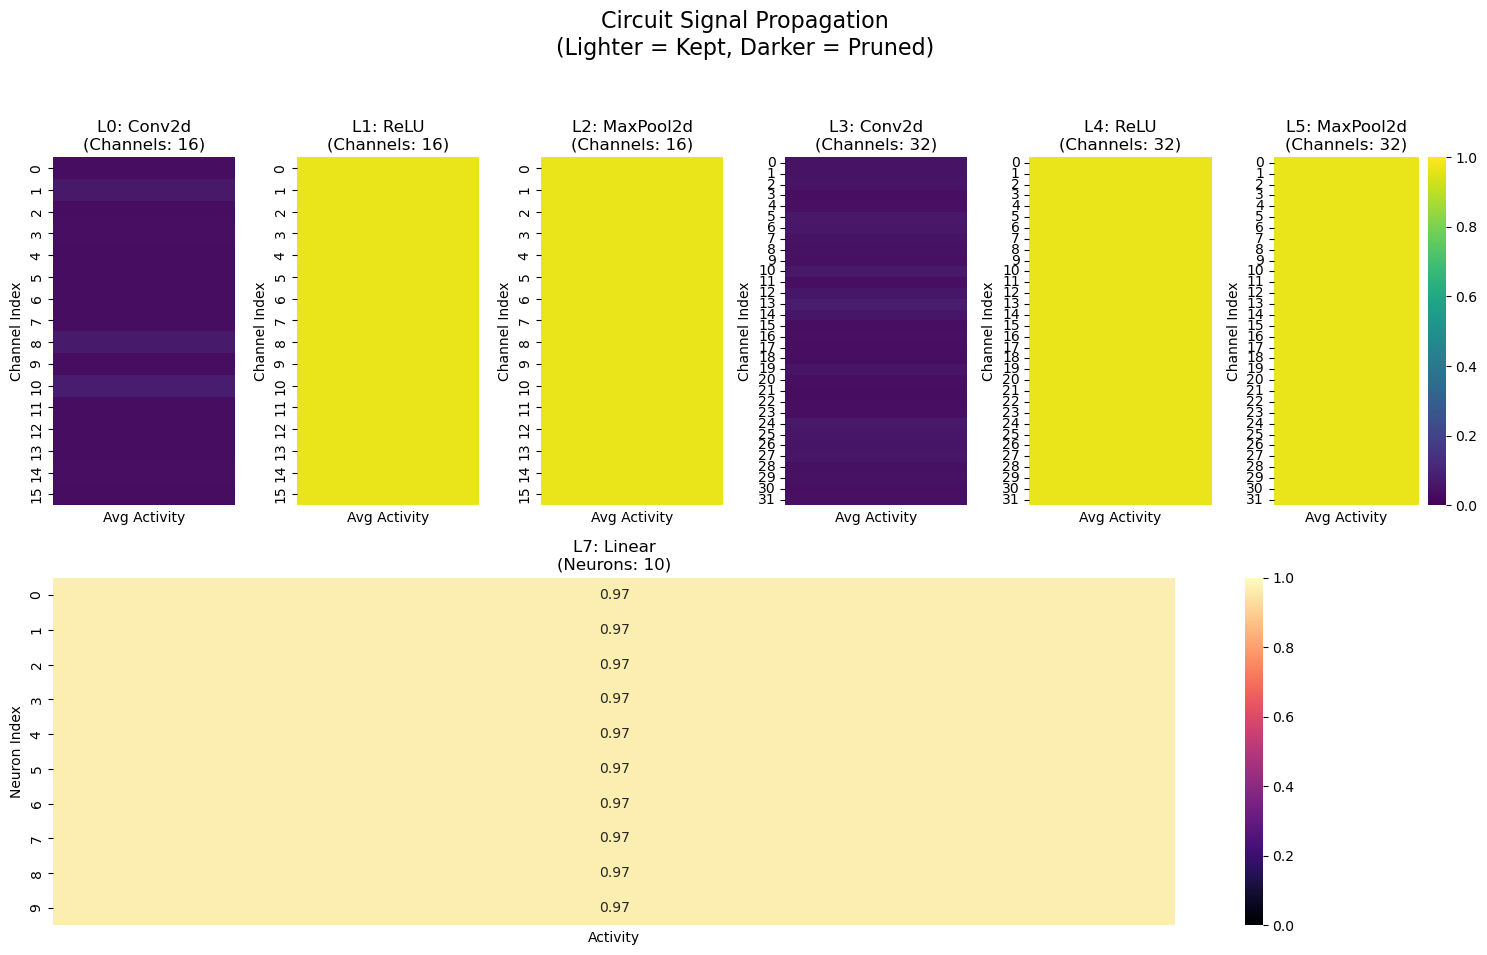


Visualization saved to circuit_visualization.png
Saved visualization to: circuit_viz_class_4.png


In [362]:
circuit_0 = run_class_circuit(class_idx=4, model=model, epochs=20,l0_lambda=4e+1, lr=1e-1, mean_ablation=True)

In [138]:
x = torch.randn(1,1,28,28)
circuit_0(x,cache=True)

tensor([[38.5204, 36.3722, 39.9807, 38.9221, 38.0748, 38.7640, 37.9762, 37.4859,
         38.5098, 38.6921]], grad_fn=<AddBackward0>)

In [139]:
x = torch.randn(1,1,28,28)
circuit_0(x)


tensor([[38.5204, 36.3722, 40.1769, 38.9221, 38.0748, 38.7640, 37.9762, 37.4859,
         38.5098, 38.6921]], grad_fn=<AddBackward0>)

In [275]:
trainloader, testloader = train.load_dataset("mnist-baseline")


/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [364]:
circuit_0.mean_ablation

False

In [363]:
circuit_0.mean_ablation = False

In [302]:
invert_masks(circuit_0)


In [303]:
active_neurons(circuit_0)

tensor([  966,   994,   996,   998,  1073,  1101,  1126,  1127,  1137,  1192,
         1194,  1220,  1221,  1222,  1247,  1274,  1275,  2528,  2529,  2530,
         2532,  2534,  2535,  2556,  2557,  2558,  2563,  2584,  2585,  2590,
         2618,  2640,  2641,  3032,  3033,  3034,  3035,  3036,  3037,  6512,
         6566,  6567,  6568,  6569,  6594,  6595,  6596,  6597,  6622,  6623,
         6624,  6625,  6652,  6653,  6708,  6734,  6735,  6763,  6788,  6789,
         6790,  6791,  6817,  6844,  6845,  6873,  6900,  6929,  7995,  8019,
         8046,  8047,  8071,  8073,  8076,  8077,  8078,  8079,  8080,  8081,
         8082,  8083,  8097,  8098,  8099,  8100,  8101,  8104,  8106,  8107,
         8108,  8109,  8110,  8111,  8126,  8136,  8138,  8139,  8153,  8154,
         8155,  8164,  8166,  8167,  8194,  8215,  8302,  8519,  8520,  8521,
         8526,  8527,  8528,  8529, 11210, 11239, 12619, 12800, 12801, 12815,
        12829, 12843, 12884, 12885, 12995, 13009, 13249, 13390, 

In [291]:
class_wise_acc(model, testloader, [0,1,2,3,4,5,6,7,8,9], device)

/home/cabbagepatch/miniconda3/envs/new/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{0: 0.9887755101939921,
 1: 0.9832599118856101,
 2: 0.9437984496032579,
 3: 0.9306930692977159,
 4: 0.9460285132286556,
 5: 0.9271300448326555,
 6: 0.9676409185702751,
 7: 0.9231517509637827,
 8: 0.9117043121056293,
 9: 0.9306243805656034}

In [298]:
class_wise_acc(circuit_0, testloader, [0,1,2,3,4,5,6,7,8,9], device)

{0: 0.9173469387661495,
 1: 0.995594713647616,
 2: 0.8875968992162055,
 3: 0.9435643564263013,
 4: 0.8879837067119349,
 5: 0.8621076233087207,
 6: 0.9916492693007135,
 7: 0.27431906614519147,
 8: 0.6365503080016781,
 9: 0.8543111991986688}

In [299]:
neurons = active_neurons(circuit_0)

In [ ]:
neurons = active_neurons(circuit_0)
len(neurons)

tensor([ 1074,  1127,  1128,  1129,  1130,  1131,  1156,  1157,  1158,  1159,
         1183,  1185,  1190,  1191,  1192,  1194,  1195,  1196,  1213,  1219,
         1220,  1221,  1222,  2756,  2785,  6533,  6560,  6562,  6567,  6568,
         6569,  6588,  6589,  6591,  6595,  6596,  6597,  6616,  6617,  6618,
         6622,  6623,  6624,  6625,  6644,  6651,  6652,  6653,  6678,  6679,
         6680,  6681,  6707,  6708,  6736,  7994,  7995,  8052,  8187,  8214,
         8215,  8216,  8239,  8240,  8241,  8242,  8243,  8244,  8245,  8248,
         8267,  8268,  8269,  8270,  8271,  8272,  8295,  8296,  8297,  8298,
         8300,  8302,  8303,  8304,  8305,  8306,  8328,  8330,  8332, 11266,
        11297, 11302, 12618, 12622, 12636, 12828, 12829, 12884, 12999, 13039,
        13391, 13394, 13573, 13590, 13604, 13612, 13613, 13672, 13800, 13808,
        13809, 13853, 13868, 13965, 14201, 14593, 14596, 14605, 14610, 14859,
        14971, 15043, 15057, 15070, 15141, 15142, 15143, 15155, 

In [371]:
idxs = neurons[90:]

Step 0 | Act: 54.41 | TV: 1765.53


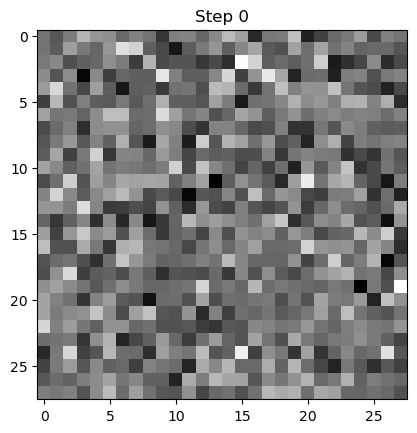

Step 100 | Act: 1214.59 | TV: 977.53


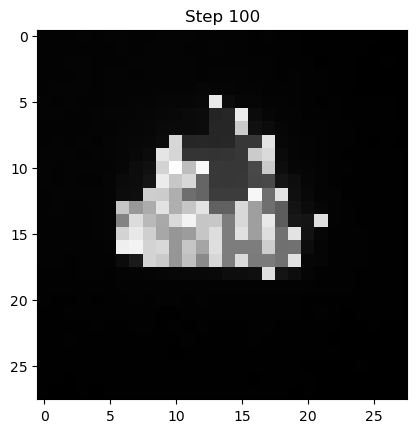

Step 200 | Act: 2392.10 | TV: 1766.34


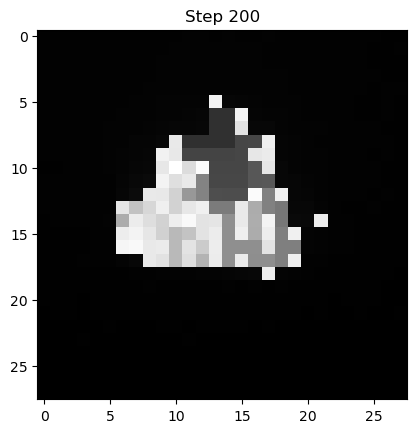

Step 300 | Act: 3565.20 | TV: 2544.73


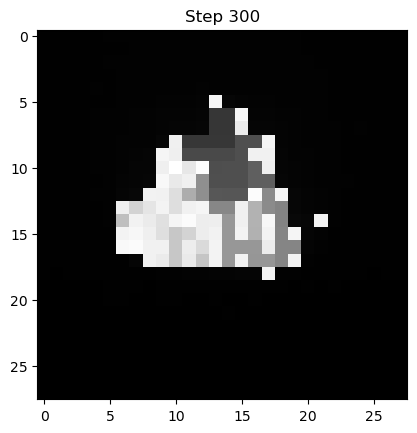

Step 400 | Act: 4736.55 | TV: 3316.68


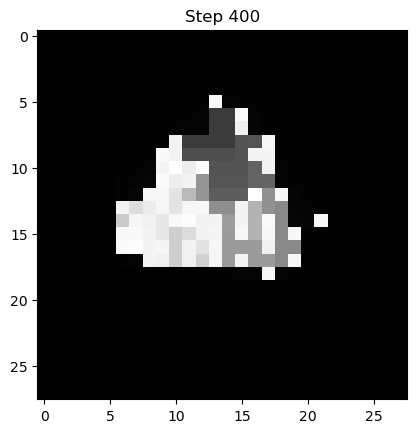

Step 500 | Act: 5906.96 | TV: 4085.99


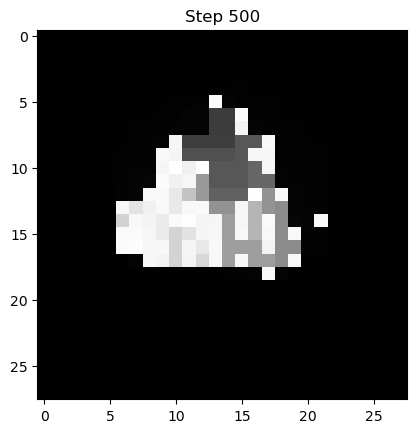

Step 600 | Act: 7076.78 | TV: 4852.27


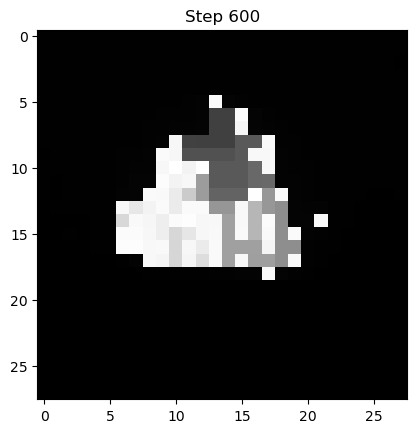

Step 700 | Act: 8246.21 | TV: 5616.66


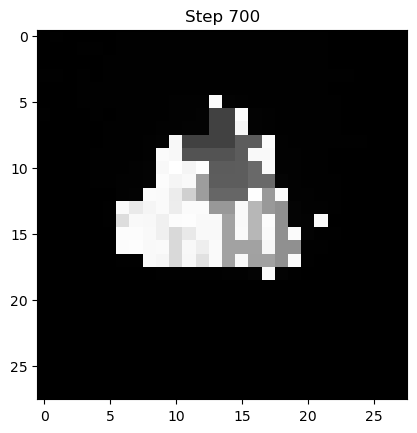

Step 800 | Act: 9416.60 | TV: 6381.08


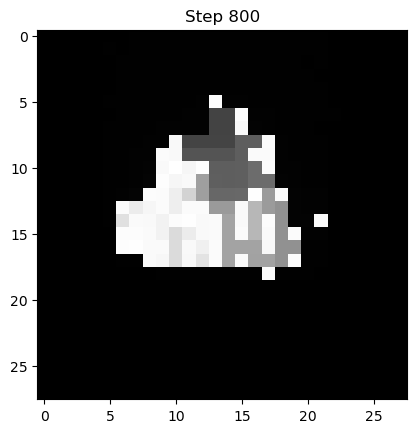

Step 900 | Act: 10634.95 | TV: 7199.85


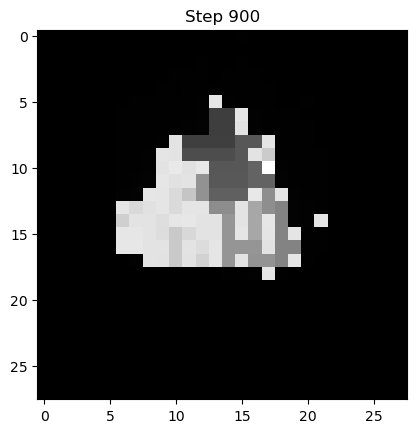

In [ ]:
_ = visualize_optimal_input_robust(circuit_0, idxs, inp_shape, steps=1000, tv_weight=0.02, l2_weight=0.02)